<a href="https://colab.research.google.com/github/ChaithanyaSaiB/UMBC-DATA606-Capstone/blob/main/notebooks/Exploration_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import joblib

In [6]:
# Load the preprocessed data
data = pd.read_csv('/content/combined_preprocessed.csv')

In [7]:
data.tail()

,ID,DateTime,Article Title and Link,URL,Content
11814,144952345170690052,Fri Dec 09 01:31:46 +0000 2011,"Shift work: Good for your pocketbook, bad for ...",http://lat.ms/srI28g,job remain gainfully employ take toll health e...
11815,144936916838649857,Fri Dec 09 00:30:28 +0000 2011,Hold the pasta: Starchy food linked to breast ...,http://lat.ms/vopkPz,post correct see note bottom detail another re...
11816,144917037414756354,Thu Dec 08 23:11:28 +0000 2011,"Chronic pain is common child complaint, study ...",http://lat.ms/sqbbYO,chronic pain usually problem affect adult stud...
11817,144881597869592576,Thu Dec 08 20:50:39 +0000 2011,"Sporadic low-carb diets may help lower weight,...",http://lat.ms/vz4beE,intermittent low carb diet could standard low ...
11818,144861369597050880,Thu Dec 08 19:30:16 +0000 2011,"O.B. Ultra tampons are coming back, and the co...",http://lat.ms/tu6n9S,woman rejoice ob ultra tampon store shelf comp...


In [8]:
data['Content'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11819 entries, 0 to 11818
Series name: Content
Non-Null Count  Dtype 
--------------  ----- 
11818 non-null  object
dtypes: object(1)
memory usage: 92.5+ KB


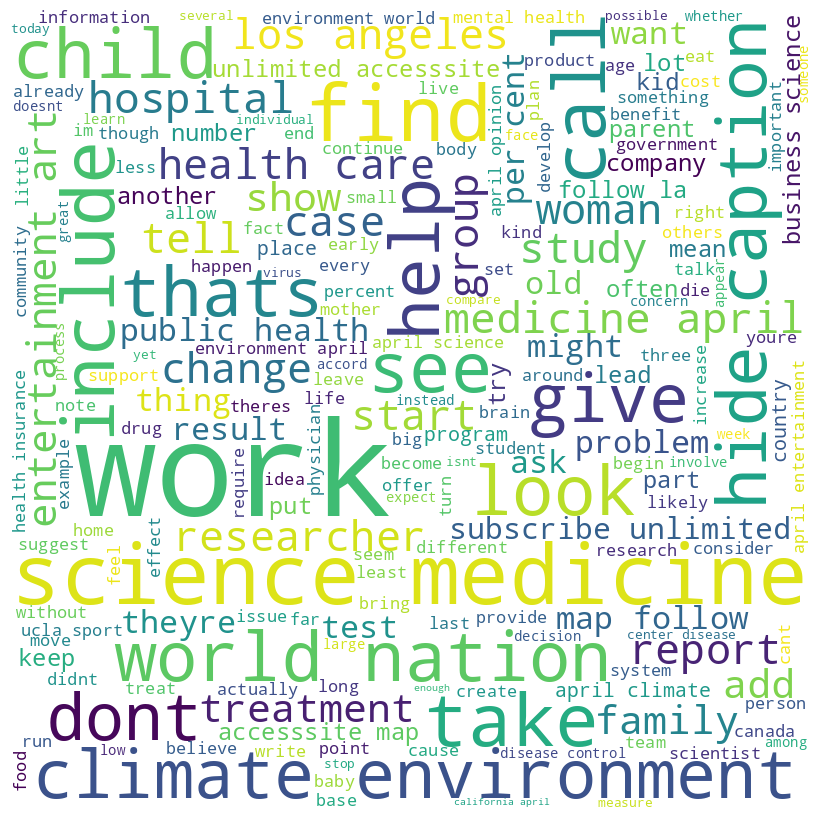

In [9]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(data['Content'].str.cat(sep=' '))

# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [10]:
data.dropna(axis=0, inplace=True)

In [11]:
# Vectorize the text data
vectorizer = CountVectorizer()
data_transformed = vectorizer.fit_transform(data['Content'])
data_transformed = pd.DataFrame(data_transformed.toarray(), columns=vectorizer.get_feature_names_out(), index=data.index)

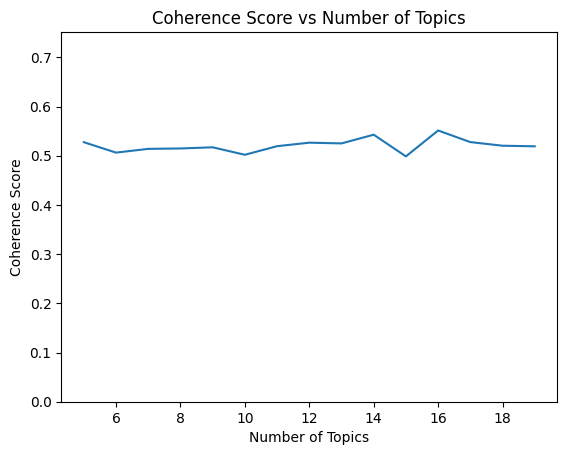

In [12]:
# Tokenize documents
tokenized_documents = [doc.split() for doc in data['Content']]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_documents)

# Create a corpus from the tokenized documents
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Set range of topics to explore
min_topics = 5
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Run LDA model for different number of topics and compute coherence score
coherence_scores = []
for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1,
                         chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot coherence score vs number of topics
plt.plot(topics_range, coherence_scores)
plt.ylim(0, max(coherence_scores) + 0.2)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

In [ ]:
# Split data into training and validation sets
train_corpus, val_corpus = train_test_split(corpus, test_size=0.2, random_state=42)

# Define hyperparameters grid
params_grid = {
    'alpha': ['auto', 'symmetric', 'asymmetric'],  # Alpha parameter
    'eta': ['auto', 0.01, 0.1],  # Eta parameter
    'passes': [5, 10, 15],  # Number of passes through the corpus
    'chunksize': [100, 200, 300],  # Number of documents to load into memory at a time
    'random_state': [42, 2022, 999],  # Random seed for reproducibility
}

best_model = None
best_coherence_score = -float('inf')

# Perform grid search
for params in ParameterGrid(params_grid):
    print("Trying parameters:", params)
    lda_model = LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=7, update_every=1, **params)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print("Coherence Score:", coherence_score)

    # Update best model if coherence score improves
    if coherence_score > best_coherence_score:
        best_model = lda_model
        best_coherence_score = coherence_score

print("Best Model Parameters:", best_model.get_topics())
print("Best Coherence Score:", best_coherence_score)

Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 5, 'random_state': 42}
Coherence Score: 0.49050279003387126
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 5, 'random_state': 2022}
Coherence Score: 0.4934493637796647
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 5, 'random_state': 999}
Coherence Score: 0.4550950917142242
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 10, 'random_state': 42}
Coherence Score: 0.4997010187381541
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 10, 'random_state': 2022}
Coherence Score: 0.4938172922358325
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 10, 'random_state': 999}
Coherence Score: 0.4612448948849511
Trying parameters: {'alpha': 'auto', 'chunksize': 100, 'eta': 'auto', 'passes': 15, 'random_state': 42}
Coherence Score: 0.4918293219391721
Trying parameter

In [ ]:
# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=7, update_every=1, chunksize=100, passes=15, alpha='asymmetric', eta=0.1, random_state=2022)

# Print topics
pprint(lda_model.print_topics())


[(0,
  '0.008*"study" + 0.007*"stephanie" + 0.006*"brain" + 0.006*"find" + '
  '0.006*"get" + 0.005*"body" + 0.005*"also" + 0.005*"work" + 0.004*"take" + '
  '0.004*"help"'),
 (1,
  '0.015*"disease" + 0.014*"health" + 0.012*"ebola" + 0.010*"virus" + '
  '0.008*"drug" + 0.007*"case" + 0.007*"infection" + 0.007*"outbreak" + '
  '0.007*"hospital" + 0.006*"cdc"'),
 (2,
  '0.068*"sleep" + 0.031*"acetaminophen" + 0.021*"gay" + 0.017*"cox" + '
  '0.014*"lgbt" + 0.011*"peanut" + 0.009*"tylenol" + 0.009*"night" + '
  '0.008*"tablet" + 0.008*"infant"'),
 (3,
  '0.020*"daniel" + 0.013*"get" + 0.011*"family" + 0.010*"tell" + '
  '0.009*"illness" + 0.009*"mental" + 0.009*"child" + 0.008*"take" + '
  '0.008*"dont" + 0.008*"hospital"'),
 (4,
  '0.030*"food" + 0.027*"weight" + 0.024*"eat" + 0.019*"pound" + 0.015*"lose" '
  '+ 0.013*"diet" + 0.012*"kid" + 0.011*"healthy" + 0.011*"child" + '
  '0.011*"fat"'),
 (5,
  '0.017*"health" + 0.012*"cancer" + 0.011*"care" + 0.009*"drug" + '
  '0.008*"accord" + 0

**Topics and their keywords**

1. **Vaccination and Measles**:health, care, hospital, would, insurance, family, also, marijuana, plan, accord

2. **Medical Treatments and Marijuana**: case, disease, health, virus, infection, water, accord, symptom, flu, air

3. **Health Research and Findings**: food, weight, pound, eat, body, product, calorie, exercise, make, also

4. **Childhood Mental Health and Education**: surgery, sleep, procedure, surgeon, hour, device, seizure, blood, injury, body

5. **Infectious Diseases and Hygiene**: cancer, drug, disease, cell, treatment, vaccine, transplant, baby, world, case

6. **Food and Nutrition**: s, illness, family, life, son, would, mother, thing, home, child

7. **Family Health and Illness**: study, brain, child, also, heart, find, woman, age, life, research

In [ ]:
topic_names = [
    "Vaccination and Measles",
    "Medical Treatments and Marijuana",
    "Health Research and Findings",
    "Childhood Mental Health and Education",
    "Infectious Diseases and Hygiene",
    "Food and Nutrition",
    "Family Health and Illness",
    "Personal Health and Weight Management",
    "Healthcare System and Cases"
]

# Calculate document-topic distribution
document_topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

# Calculate average probabilities for each topic
topic_frequencies = defaultdict(float)
for doc_topics in document_topic_distribution:
    for topic, prob in doc_topics:
        topic_frequencies[topic] += prob

num_documents = len(document_topic_distribution)
topic_frequencies = {topic: freq / num_documents for topic, freq in topic_frequencies.items()}

# Sort topics by frequency
sorted_topic_frequencies = sorted(topic_frequencies.items())
topic_frequencies = [tup[1] for tup in sorted_topic_frequencies]

# Print topic frequencies
for topic, value in zip(topic_names, topic_frequencies):
    print("{} topic has {:.2f} average probability in documents".format(topic, value))

Vaccination and Measles topic has 0.41 average probability in documents
Medical Treatments and Marijuana topic has 0.15 average probability in documents
Health Research and Findings topic has 0.00 average probability in documents
Childhood Mental Health and Education topic has 0.14 average probability in documents
Infectious Diseases and Hygiene topic has 0.08 average probability in documents
Food and Nutrition topic has 0.16 average probability in documents
Family Health and Illness topic has 0.05 average probability in documents


In [ ]:
# Create horizontal bar chart
fig = go.Figure(go.Bar(
    x=topic_frequencies,
    y=topic_names,
    orientation='h'
))

# Customize layout
fig.update_layout(
    title='Topics and their average probabilities',
    xaxis_title='Probabilities',
    yaxis_title='Topics',
    yaxis=dict(autorange='reversed', tickmode='linear')  # Reverse the order of categories for horizontal bar chart
)

# Show plot
fig.show()


In [ ]:
joblib.dump(lda_model, "lda_model.sav")
dictionary.save('dictionary.sav')